In [2]:
from scipy import sparse
import pandas
import numpy as np
from matplotlib import pyplot as plt
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.tv as tv
import sklearn.preprocessing 

def Ak_from_pairs(k,p):
    Ak = sparse.lil_matrix((int(p*(p-1)/2),p*p))
    ij=0
    for i in range(0,p-1):
        for j in range(i+1,p):
            #print(i*p+k,j*p+k,ij)
            if (i==k)|(j==k):
                Ak[ij,i*p+j]=1
                Ak[ij,j*p+i]=-1
            else:
                Ak[ij,i*p+k]=1
                Ak[ij,j*p+k]=-1
            ij=ij+1
    #return(Ak)
       
    to_keep = list(set(range(Ak.shape[1]))-set(range(0,p*p,p+1)))    
    Aknew = sparse.lil_matrix(sparse.csr_matrix(Ak)[:,to_keep])     
    return(Aknew)




def linear_operator_from_num_variables(num_variables):
    """Generates the linear operator for the TV lasso Nesterov function
    from number of variables.

    Parameters:
    ----------
    num_variables : Integer. The total number of variables, including the
            intercept variable(s).

    """
    A = list()
    for k in range(0,num_variables):
        Ak = Ak_from_pairs(k,num_variables)
        A.append(Ak.tocsr())
    return A

def beta2Beta(beta,p): 
    Beta=np.zeros((p,p))
    for j in range(0,(p-1)):
        for i in range(0,p):
            k=i
            l=j
            if j>=i:
                l=j+1
            Beta[k,l]=beta[i*(p-1)+j]
    return(Beta)  

def precision2regression(K):
    p=K.shape[0]
    M=np.zeros((p,p))
    for i in range(0,p):
        for j in range(0,p):
            if i!=j:
                M[i,j]= - K[i,j]/K[i,i]
    return(M)     


def conesta_rwrapper(X, lam1, lam2):
    X=np.array(X)
    n=X.shape[0]
    p=X.shape[1]
  
    X=sklearn.preprocessing.scale(X)
    y=X.reshape(n*p,1,order='F')
    Xvec=np.delete(np.kron(np.identity(p),X),range(0,p*p,p+1),axis=1)
    A=linear_operator_from_num_variables(p)
  
    l = lam1  # l1 lasso coefficient
    k = 0.0  # l2 ridge regression coefficient
    g = lam2 
  
    hgmm = estimators.LinearRegressionL1L2TV(l, k, g, A, mu=0.001,
                                           algorithm=algorithms.proximal.CONESTA(max_iter=1000), mean=False)
    res = hgmm.fit(Xvec,y)
    Beta=beta2Beta(res.beta,p)
    #print(res.score(Xvec, y))
  
    return(Beta)


In [58]:
X = np.array([[0,2,1],[2,0,5],[4,2,0],[3,5,7]])
beta = np.array([[0,0.5,0.6],[0.9,0,0.7],[0.2,0.5,0]])

In [4]:
# minus and plus lines with reodering the coefficients

def minus_lines(i, j, Beta, ni = 1, nj = 1):
    Y_coeffs = Beta[i, :].copy()
    X_coeffs = Beta[j, :].copy()
    X_i = X_coeffs[i]
    X_coeffs[i] = X_coeffs[j]
    X_coeffs[j] = X_i
    return ni*Y_coeffs - nj*X_coeffs

def plus_lines(i, j, Beta, ni = 1, nj = 1):
    Y_coeffs = Beta[i, :].copy()
    X_coeffs = Beta[j, :].copy()
    X_i = X_coeffs[i]
    X_coeffs[i] = X_coeffs[j]
    X_coeffs[j] = X_i
    return ni*Y_coeffs + nj*X_coeffs

In [5]:
# Cost function

def cost(Beta, X, lambda1=0, lambda2=0):
    p = X.shape[1]
    P2 = 0
    
    # loss term
    L = np.sum(np.vectorize(lambda i: np.linalg.norm(X[:,i] - X @ Beta[i,:])**2)(range(p)))
    
    # fuse-group lasso penalty
    for i in range(p-1):
        for j in range(i+1,p):
            P2 = P2 + np.linalg.norm(minus_lines(i, j, Beta))
    
    # lasso penalty
    P1 = np.sum(np.abs(Beta))
    
    return L + lambda1*P1 + lambda2*P2

In [ ]:
def hggm2(X, 
          lambda1=0, 
          fuse_thresh = 10^-3, 
          maxit = 1000, 
          silent = TRUE, 
          distance = "euclidean", 
          solver = "conesta", 
          lambda2_start = 1e-4, 
          lambda2_factor = 1.5):
    ## Initialisations
    X = X.copy()
    X = np.array(X)
    p = X.shape[1]
    gains = np.zeros(p-1)
    merge = np.zeros((p-1, 2)) # matrix of merging clusters at each level
    level = 0
    labels = -np.arange(p)                         # vector of clusters labels
    clusters = np.arange(p)
  
    lambda2 = lambda2_start.copy()
    old_lambda2 = 0
    old_lambda1 = lambda1
    Beta = conesta_rwrapper(X, lambda1, old_lambda2)
  
    old_costf = costf =  cost(Beta, X, lambda1, old_lambda2)
  
  
    t = 1 # index for the out list.
    iteration = 0
    out = []
    out[0] = {"Beta" : Beta, "clusters" : clusters}
    #names(out)[[1]] = "level0"
    prev = len(np.unique(clusters))
    ## End Initialisations
  
  
    ## Loop until all the variables merged
    while (len(np.unique(clusters)) > 1):
        oldp = X.shape[1]
        iteration = iteration + 1
    
    
        Beta = conesta_rwrapper(X, lambda1, lambda2)
        print(lambda1)
    
        ## Update distance matrix
        diffs = dist_beta(Beta, distance = distance)
    
        ## Clustering starts here
        pairs_to_merge = np.concatenate(np.where(dist_beta(beta,"relative")<=fuse_thresh)).reshape((2,-1)).T
    
    if (pairs_to_merge.shape[0] != 0):
        gain_level = costf - old_costf
        out_mergeproc = merge_proc(pairs_to_merge, clusters, X, Beta, level, gain_level, gains, labels, merge)
      
        X        = out_mergeproc['X']
        Beta     = out_mergeproc['Beta']
        clusters = out_mergeproc['clusters']
      
        level    = out_mergeproc['level']
        gains    = out_mergeproc['gains']
        merge    = out_mergeproc['merge']
        labels   = out_mergeproc['labels'] 

    ## Clustering ends here
    
    costf = cost(Beta, X, lambda1, lambda2)
    #cat("nclusters =", length(unique(clusters)), "lambda2", lambda2, "cost =", costf, "\n")
    
    gains[np.isnan(gains)] = old_costf - costf
    old_costf = costf
    
    if(len(np.unique(clusters)) != prev):
        out[[t]] = {"Beta" = Beta, "clusters" = clusters}
        #names(out)[[t]] <- paste0("level", (p-length(unique(clusters))))
        prev <- len(np.unique(clusters))
        t = t + 1
    
    old_lambda2 = lambda2
    
    lambda2 = lambda2*lambda2_factor
  
    height      = cumsum(gains)
    tree        = list(merge = merge,
                      height = height,
                      order = rev(clusters),
                      labels = paste("",1:p),
                      gains=gains)
    class(tree) = "hclust"
    #tree = vegan:::reorder.hclust(tree, 1:p)
  
  
    result = {"out" = out, "tree" = tree}
  
    return(result) 

In [47]:
def merge_proc(pairs_to_merge, 
               clusters, 
               X,
               Beta,
               level,
               gain_level,
               gains,
               labels,
               merge):
    X = X.copy()
    Beta = Beta.copy()
    for l in range(pairs_to_merge.shape[0]):
        pair_to_merge = pairs_to_merge[l,:]
    
        # can also take the 1st element cause it's always the min for a upper-triangular matrix
        i = np.min(pair_to_merge)
        j = np.max(pair_to_merge)
    
        if(i != j):
      
            # merge lines/cols in Beta and X
            Beta = merge_beta(Beta, pair_to_merge, clusters)
            X = mergeX(X, pair_to_merge, clusters)
      
            # update dendrogram
            merge[level, :] = [labels[i], labels[j]]
            labels = merge_labels(pair_to_merge, labels, level)
            gains[level-1] = 0 if l>0 else np.nan
      
            # merge clusters
            clusters[clusters == j] = i 
            clusters[clusters > j] = clusters[clusters > j] - 1
      
            # update the rest of the table with the new clusters
            pairs_to_merge[pairs_to_merge == j] = i
            pairs_to_merge[pairs_to_merge > j] = pairs_to_merge[pairs_to_merge > j] - 1
            
            level <- level + 1
            
    out_mergeproc = {"clusters" : clusters, 
                     "Beta" : Beta, 
                     "X" : X, 
                     "level" : level, 
                     "gains" : gains, 
                     "merge" : merge, 
                     "labels" : labels}
    return(out_mergeproc)


In [8]:
# distances Beta
def dist_beta(Beta, distance = "euclidean"):
    K = Beta.shape[1]
    
    if (K != 1):
        diffs = np.ones((K, K))*np.inf
        for i in range(K-1):
            for j in range(i+1,K):
                diffs[i,j] = np.linalg.norm(minus_lines(i, j, Beta))
    
        if (distance == "relative"):
            Dsum = np.ones((K, K))
            for i in range(K-1):
                for j in range(i+1,K):
                    Dsum[i,j] = np.linalg.norm(Beta[i,:]) + np.linalg.norm(Beta[j,:])

            diffs = diffs/Dsum

    else:
        diffs = np.zeros((1,1))
  
    return diffs

In [73]:
# Merge X
def mergeX(X, pair_to_merge, clusters):
    X = X.copy()
    i = np.min(pair_to_merge)
    j = np.max(pair_to_merge)
  
    ni = np.sum(clusters == i)
    nj = np.sum(clusters == j)
  
    X[:,i] = (ni*X[:,i] + nj*X[:,j])/(ni + nj)
    X = np.delete(X, j, 1)
    
    return X

#' Merge Beta
#' Different types of merging and their effect
def merge_beta(Beta, pair_to_merge, clusters):
    Beta = Beta.copy()
    i = min(pair_to_merge)
    j = max(pair_to_merge)
  
    ni = np.sum(clusters == i)
    nj = np.sum(clusters == j)
  
    Beta[i,:] = plus_lines(i, j, Beta, ni, nj) / (ni + nj)
    Beta = np.delete(np.delete(Beta, j, 1), j, 0)
  
    return Beta

#' Merge labels
def merge_labels(merged_pair, labels, level):
    i = min(merged_pair)
    j = max(merged_pair)
    labels[i] = level
    labels = np.delete(labels, j , None)
    return labels

In [84]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

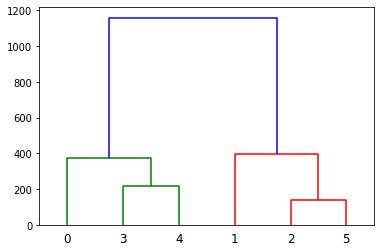

In [98]:
ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(ytdist, 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z)

[[ 5.          6.          0.          2.        ]
 [ 2.          7.          0.          2.        ]
 [ 0.          4.          1.          2.        ]
 [ 1.          8.          1.15470054  3.        ]
 [ 9.         10.          2.12132034  4.        ]
 [ 3.         12.          4.11096096  5.        ]
 [11.         13.         14.07183949  8.        ]]


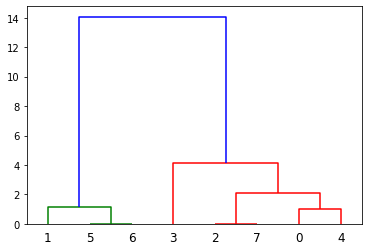

In [94]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = hierarchy.linkage(X, 'ward')
print(Z)
dn = hierarchy.dendrogram(Z)
plt.show()

In [95]:
X

[[2], [8], [0], [4], [1], [9], [9], [0]]